## Shape to bucket

This notebook takes as input:
- A random `.geojson`
- A target zoom level `z`
- A target time window `t1`-`t2`
- An instrument `instrument`
- A destination, local ~~or an Azure Bucket.~~
~~- Uses Dask to paralelize~~

and uses the Planetary Computer to retrieve all tiles at zoom level `z` with raw data from instrument `instrument` as close as possible to `t2` and always after `t1`.

As an example we will retrieve all zoom tiles at `z14` within `Asturias` from `Sentinel-2` in `2023`.

----
This is our RoI.


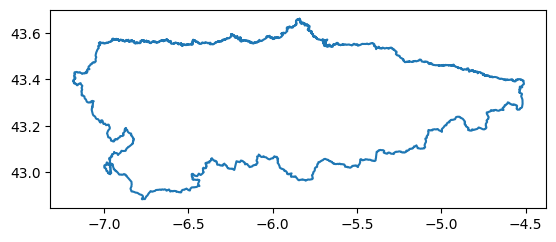

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load GeoJSON from URL
geojson_url = "https://gist.githubusercontent.com/brunosan/fd87f56da93cc4c91dbe30472988e973/raw/43e019f6d7619f1aafc5e0c2a8089c22440f1527/asturias.geojson"
asturias_roi = gpd.read_file(geojson_url)
asturias_roi.plot()
plt.show()


Now we cover the extend with tiles at the requested zoom level, getting a list of `[x,y,z]` tiles

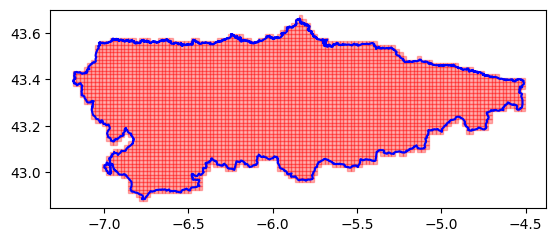

3597


In [10]:
from tile_tools import cover
import geojson
import clay_tools
import os
from IPython.display import display, clear_output



def get_cover_tiles(roi,zoom, do_plot=True,folder="./"):
    """
    Get the tiles at zoom level z that fully cover the geometry
    """
    geom_geojson = geojson.Polygon([roi.__geo_interface__['features'][0]['geometry']['coordinates']])
    tiles_list = cover.tiles(geom_geojson, zoom) # list of (x, y, z) tiles

    if do_plot:
        plot_cover_tiles(roi,tiles_list,folder=folder)
    return tiles_list

def plot_cover_tiles(roi, tiles_list, folder="./"):
    fig, ax = plt.subplots()
    roi.plot(ax=ax, color='blue')
    for tile in tiles_list:
        bbox = clay_tools.tile_bbox(*tile)
        file_path = os.path.join(folder, f"{tile[2]}-{tile[0]}-{tile[1]}.tif")
        fill_color = 'green' if os.path.exists(file_path) else 'red'
        ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], alpha=0.3, color=fill_color))
    
    clear_output(wait=True)
    display(fig)
    plt.close(fig)



zoom = 14
tiles_list = get_cover_tiles(asturias_roi,zoom, do_plot=True,folder="test_data")
print(len(tiles_list))


For each tile, now let's use the PC API to find and retreive the tiles.

In [11]:
import rasterio
import functools
import planetary_computer
import pystac_client
import clay_tools
from datetime import datetime, timedelta
import time
import numpy as np

def PC_get_url(x, y, z, collection, asset_id, scale=1):
    #the Planetary Computer renders on-the-fly the requested tile, of a given asset_ID, collection and optional parameter
    return f"https://planetarycomputer.microsoft.com/api/data/v1/item/tiles/WebMercatorQuad/" + \
           f"{z}/{x}/{y}@{scale}x.tif?collection={collection}&item={asset_id}&assets=visual&asset_bidx=visual%7C1%2C2%2C3&nodata=0"

def request_tile_data(z, x, y, collection, start_date, end_date,cloud_cover=20,max_retries=5,reduction="none",at_most=10,verbose=False):
    bbox = clay_tools.tile_bbox(z, x, y)
    bbox_str = ','.join(str(coord) for coord in bbox)  # Convert the bbox list to a string
    assets_id = PC_get_assets_id(start_date, end_date, bbox_str, cloud_cover, collection,verbose=verbose)
    if assets_id is None:
        if verbose:
            print(f"No data for {z}, {x}, {y}")
        #print(PC_get_url(z,*clay_tools.center_lonlat_of_bbox(bbox),collection))
        return None

    if len(assets_id) > at_most:
        if verbose:
            print(f"Taking only {at_most} most recent from the {len(assets_id)} assets for {z}, {x}, {y}, {collection}, {start_date}, {end_date}")
        assets_id=assets_id[-at_most:]

    match reduction:
        case "none":
            url = PC_get_url(z, x, y, collection, assets_id[-1], scale=1)
            return rasterio.open(url).read()
        case "median":
            #make cube of data
            tile_data = []
            for asset_id in assets_id:
                retries = 0
                while retries <= max_retries:
                    try:
                        if verbose:
                            print(f"Getting {len(tile_data) + 1} of {len(assets_id)}")
                        url = PC_get_url(z, x, y, collection, asset_id, scale=1)
                        tile_data.append(rasterio.open(url).read())
                        break  # Successful, exit retry loop
                    except:
                        retries += 1
                        if retries > max_retries:
                            if verbose:
                                print(f"Max retries reached for asset {asset_id}")
                            continue  # Skip this asset
                        if verbose:
                            print(f"Pausing {2 ** retries} seconds then retrying asset {asset_id}")
                        time.sleep(2 ** retries)  # Exponential backoff
            #make median on first dimension using numpy
            tile_data = np.array(tile_data)
            tile_data = np.median(tile_data, axis=0).astype('uint8')
            if verbose:
                print("Got all data\t")
            return tile_data
        case _:
            raise ValueError(f"Reduction {reduction} not supported")

# Add caching to the get_asset_id function
@functools.lru_cache(maxsize=256)
def PC_get_assets_id(start_date, end_date, bbox_str, cloud_cover, collection,verbose=False):
    #Use the STAC API of the Planetary Computer to get the asset_ids that meets the criteria
    bbox = [float(coord) for coord in bbox_str.split(',')] 
    # start_date = datetime.strptime(start_date, "%Y-%m-%d")
    # end_date    = datetime.strptime(end_date, "%Y-%m-%d")
    time_range = f"{start_date}/{end_date}"
    catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    )
    search = catalog.search(
        collections=[collection],
        bbox=bbox,
        datetime=time_range,
        query={"eo:cloud_cover": {"lt": cloud_cover}},
    )
    len_ids = len(list(search.item_collection()))
    if len_ids == 0:
        if verbose:
            print(f"No items")
        return None
    items = list(
        i for i in search.items() if clay_tools.intersection_percent(i, clay_tools.bbox_to_aoi(bbox)) > 95
    )
    if len(items) == 0:
        if verbose:
            print(f"No items with intersection > 95%")
        return None
    return [i.id for i in items]

def process_list(tiles_list,collection, start_date, end_date,cloud_cover=20,max_retries=5,reduction='none',at_most=10,verbose=False,folder='./'):
    for i,tile_zxy in enumerate(tiles_list):
        print(f"Tile {i} of {len(tiles_list)}")
        if not os.path.exists(f"{folder}/{tile_zxy[2]}-{tile_zxy[0]}-{tile_zxy[1]}.tif"):
            tile_data = request_tile_data(*tile_zxy, collection, start_date, end_date,cloud_cover=cloud_cover,max_retries=5,reduction=reduction,at_most=at_most,verbose=verbose)
            if tile_data is not None:
                clay_tools.save_tif_tile(*tile_zxy, tile_data,folder=folder)
        plot_cover_tiles(asturias_roi,tiles_list,folder=folder)

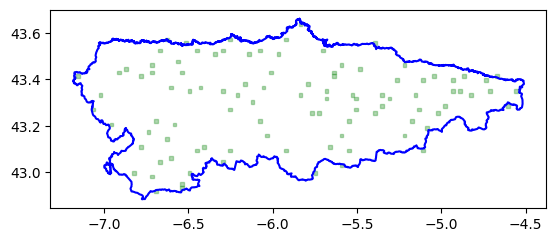

In [13]:

#Latest single Image
import os
start_date, end_date = "2023-01-01", "2023-12-31"
collection = "sentinel-2-l2a"
reduction="none"
folder="2013_latest"
tiles_list = get_cover_tiles(asturias_roi,zoom, do_plot=True)
process_list(tiles_list[:100],collection, start_date, end_date,cloud_cover=20,max_retries=5,reduction=reduction,at_most=10,verbose=False,folder=folder)



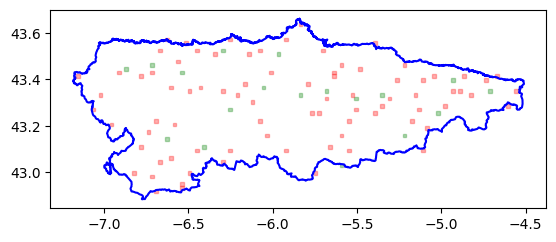

Tile 18 of 100
Getting 1 of 28
Getting 2 of 28
Pausing 2 seconds then retrying asset S2B_MSIL2A_20231006T112119_R037_T29TQJ_20231006T161832
Getting 2 of 28
Getting 3 of 28
Getting 4 of 28
Getting 5 of 28
Getting 6 of 28
Getting 7 of 28
Getting 8 of 28
Getting 9 of 28
Getting 10 of 28


In [14]:
#Last year median Image
import os
start_date, end_date = "2023-01-01", "2023-12-31"
collection = "sentinel-2-l2a"
reduction="median"
folder = "2023-median"
tiles_list = get_cover_tiles(asturias_roi,zoom, do_plot=True)
process_list(tiles_list[:100],collection, start_date, end_date,cloud_cover=20,max_retries=5,reduction=reduction,at_most=100,verbose=True,folder=folder)


In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Define the folders containing your TIFF files
folder1 = '2023-median'
folder2 = '2013_latest'

# List the filenames in one of the folders (assuming both folders have the same filenames)
filenames = os.listdir(folder1)

# Create a widget to select the pair index to display
pair_selector = widgets.IntSlider(min=0, max=len(filenames)-1, step=1, description='Pair Index:')

# Create a function to load and display pairs of TIFF files side by side
def display_tiff_pair(pair_index):
    filename = filenames[pair_index]
    tiff1 = Image.open(os.path.join(folder1, filename))
    tiff2 = Image.open(os.path.join(folder2, filename))

    # Plot side by side
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(tiff1)
    plt.title('Median')
    
    plt.subplot(1, 2, 2)
    plt.imshow(tiff2)
    plt.title('Last')
    
    plt.show()

# Display the widget and interactive plot
widgets.interactive(display_tiff_pair, pair_index=pair_selector)


interactive(children=(IntSlider(value=0, description='Pair Index:', max=17), Output()), _dom_classes=('widget-…